In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import torch 

In [3]:
PATH = os.path.abspath('..')

In [27]:
# get labeled data (excluding test)
label_csv = f'{PATH}/catalogs/SDSSspecgalsDR14_boada.csv'

n = len(list(open(label_csv))) - 1 
val_idxs = get_cv_idxs(n)

# see a few
df = pd.read_csv(label_csv, index_col='objID')
df.head()

specObjID          ra        dec         z  \
objID                                                                       
1237657070629027993   460656645643462656   42.848838  -0.087291  0.053164   
1237658203440283667  1440030424800716800  193.603250  48.774640  0.045358   
1237657071157117111   784893009903773696   22.873397   0.336578  0.095072   
1237657071698378865  1209386973525993472   32.793831   0.631794  0.042327   
1237657118404903062  1193505347646547968  117.996807  29.413908  0.121984   

                         zErr   velDisp  velDispErr  modelMag_u  \
objID                                                             
1237657070629027993  0.000007  47.39425    13.83830    18.62205   
1237658203440283667  0.000014  56.04235    14.63707    17.95715   
1237657071157117111  0.000010  59.03400    12.17910    19.92969   
1237657071698378865  0.000020  71.91644    20.22402    19.61407   
1237657118404903062  0.000007   0.00000    55.30409    19.11589   

                     modelMagErr_u  modelMag_g     ...       h_beta_flux  \
objID                                              ...                     
1237657070629027993       0.039646    17.40391     ...          77.06317   
1237658203440283667       0.024831    16.78851     ...          33.65274   
1237657071157117111       0.067595    18.54727     ...          28.92639   
1237657071698378865       0.085397    18.14444     ...          14.20437   
1237657118404903062       0.043633    18.29203     ...          79.92870   

                     h_beta_flux_err  h_delta_flux  h_delta_flux_err  \
objID                                                                  
1237657070629027993         2.665140     20.252570          2.762302   
1237658203440283667         2.762887     13.318680          3.409556   
1237657071157117111         1.585112      6.887691          1.785967   
1237657071698378865         1.500584      2.976142          2.110726   
1237657118404903062         2.623430     24.953430          2.327975   

                        d4000  d4000_err  bptclass    oh_p50  lgm_tot_p50  \
objID                                                                       
1237657070629027993  1.390432   0.016158         1  8.826264     9.676653   
1237658203440283667  1.437371   0.024805         1  8.870417     9.774070   
1237657071157117111  1.465837   0.019227         1  9.061250    10.154880   
1237657071698378865  1.391771   0.034714         1  8.606583     9.523041   
1237657118404903062  1.182455   0.016764         1  8.707049     9.862308   

                     sfr_tot_p50  
objID                             
1237657070629027993     0.130842  
1237658203440283667     0.042070  
1237657071157117111    -0.180383  
1237657071698378865    -2.125353  
1237657118404903062     0.482178  

[5 rows x 35 columns]

In [28]:
id_num = 1237657070629027993
os.path.isfile(f'{PATH}/images/{id_num}.png')

True

In [29]:
df.columns

Index(['specObjID', 'ra', 'dec', 'z', 'zErr', 'velDisp', 'velDispErr',
       'modelMag_u', 'modelMagErr_u', 'modelMag_g', 'modelMagErr_g',
       'modelMag_r', 'modelMagErr_r', 'modelMag_i', 'modelMagErr_i',
       'modelMag_z', 'modelMagErr_z', 'petroR50_r', 'petroR90_r',
       'nii_6584_flux', 'nii_6584_flux_err', 'h_alpha_flux',
       'h_alpha_flux_err', 'oiii_5007_flux', 'oiii_5007_flux_err',
       'h_beta_flux', 'h_beta_flux_err', 'h_delta_flux', 'h_delta_flux_err',
       'd4000', 'd4000_err', 'bptclass', 'oh_p50', 'lgm_tot_p50',
       'sfr_tot_p50'],
      dtype='object')

### Examine some of the data

In [30]:
image_ids = [os.path.split(fname)[1].strip('.png') for fname in glob(f'{PATH}/images/*.png')]
image_ids[:5]

['1237645879551066262',
 '1237645879577936138',
 '1237645942905438495',
 '1237645943976493208',
 '1237645943978328116']

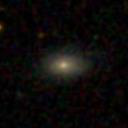

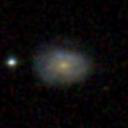

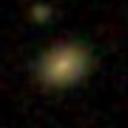

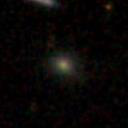

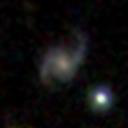

In [31]:
from IPython.display import display
for obj in df.index[:5]:
    display(PIL.Image.open(f'{PATH}/images/{obj}.png'))

### Examine distributions of each class

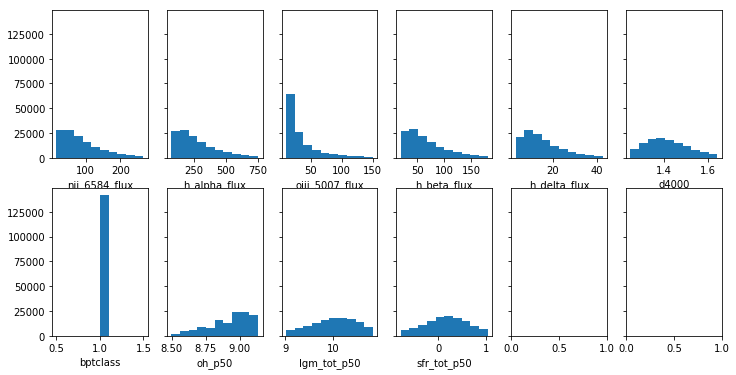

In [9]:
classes = ['nii_6584_flux', 'h_alpha_flux', 'oiii_5007_flux', 'h_beta_flux', 'h_delta_flux', 
           'd4000', 'bptclass', 'oh_p50', 'lgm_tot_p50', 'sfr_tot_p50']

fig, axes = plt.subplots(nrows=2, ncols=len(classes) // 2 + 1, figsize=(12, 6), sharey=True)

for ax, col in zip(axes.flat, classes):
    data = df[col]
    ax.hist(data, range=np.nanpercentile(data, [5, 95]))
    ax.set_xlabel(col)


Let's flag `bptclass` and move on.

## Train a simple network to predict `oh_p50`

In [10]:
label_csv = f'{PATH}/catalogs/metallicity.csv'

#df[['oh_p50']].to_csv(label_csv)

In [38]:
# load in data with transforms
arch = resnet34
sz = 32
bs = 8

In [39]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    return ImageClassifierData.from_csv(PATH, 'images', label_csv, tfms=tfms,
                    suffix='.png', val_idxs=val_idxs, test_name='images', 
                    num_workers=1, )

In [40]:
data = get_data(sz, bs)

MemoryError: 

~~It appears that a batch size of `16` pushes my RAM to the limits (maybe even triggering swap space?), but I don't get an out of memory error -- except when lots of apps are open.~~ Now that I'm using categorical morphology, this seems to be going much more quickly and is light on my memory usage.

In [118]:
# initialize network
learn = ConvLearner.pretrained(arch, data, pretrained=True)

In [119]:
# find learning rate
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 82%|████████▏ | 633/770 [01:44<00:22,  6.07it/s, loss=2.71] 

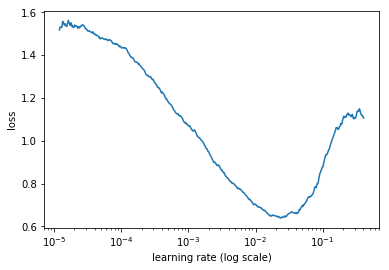

In [120]:
learn.sched.plot(n_skip_end=40)

1


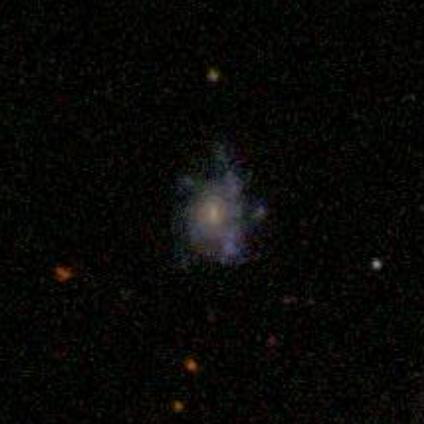

In [121]:
idx = 5 
print(learn.data.trn_y[idx])
PIL.Image.open(PATH + learn.data.trn_ds.fnames[idx])

### Start fitting the los-res images
I'm using a learning rate of $2\times 10^{-3}$, which is a little lower than initially expected.

In [122]:
lr = 2e-3
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.557335   0.50488    0.782298  
    1      0.519738   0.485871   0.786439                    
    2      0.527142   0.482443   0.785871                    


[array([0.48244]), 0.7858708892031215]

In [123]:
learn.save(f'{sz}_init-train')

Looks like loss is bottoming out already. Before training on bigger images, let's unfreeze the earlier layers and train them too.

In [124]:
# differential learning rates
learn.unfreeze()

lr = np.array([1/9, 1/3, 1]) * 1e-3
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.546762   0.524958   0.756801  
    1      0.476634   0.467746   0.78717                     
    2      0.478633   0.458754   0.793341                    
    3      0.463687   0.437847   0.805522                    
    4      0.453719   0.423542   0.811368                    
    5      0.437002   0.419754   0.813398                    
    6      0.43387    0.419426   0.812992                    


[array([0.41943]), 0.8129922858593283]

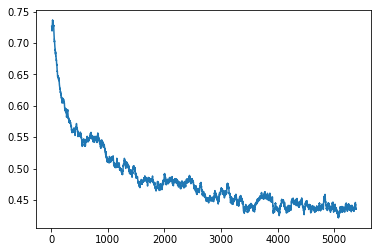

In [125]:
learn.sched.plot_loss()

In [126]:
learn.save(f'{sz}_diff-learn-1')

In [127]:
# keep going on?
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.440031   0.416184   0.814292  
    1      0.435258   0.410033   0.817864                    
    2      0.432972   0.412813   0.81754                     
    3      0.4198     0.404174   0.823955                    
    4      0.418799   0.402312   0.825254                    
    5      0.414865   0.39765    0.827365                    
    6      0.415695   0.397597   0.827609                    


[array([0.3976]), 0.8276086074184026]

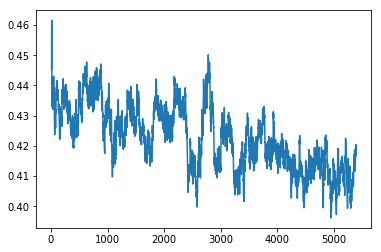

In [128]:
learn.sched.plot_loss()

In [129]:
learn.save(f'{sz}_diff-learn-2')

## What did we get wrong?

In [130]:
# predict using test-time augmentation
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds), axis=0)

In [131]:
accuracy_np(probs, y)

0.8354039788875355

In [132]:
from sklearn.metrics import confusion_matrix

preds = np.argmax(probs, axis=1)
probs = probs[:,1]

cm = confusion_matrix(y, preds)

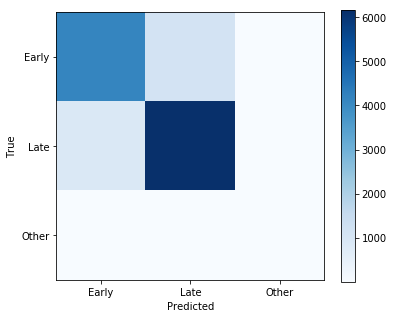

In [138]:
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Blues')
plt.xticks(range(3), data.classes)
plt.xlabel('Predicted')
plt.yticks(range(3), data.classes)
plt.ylabel('True')
plt.colorbar()

In [160]:
def rand_by_mask(mask, n=5): return np.random.choice(np.where(mask)[0], n, replace=False)

def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y) == is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


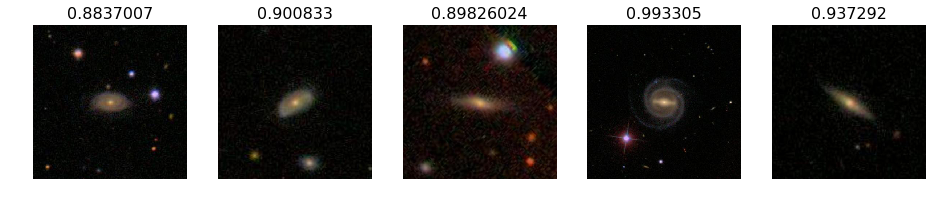

In [161]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


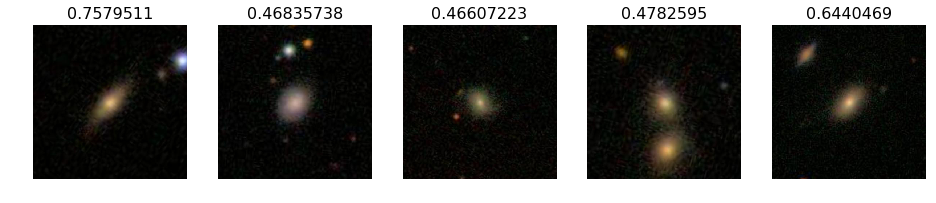

In [162]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [258]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:5]]

def most_by_correct(y, is_correct): 
    mult = -1 if is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct early-types


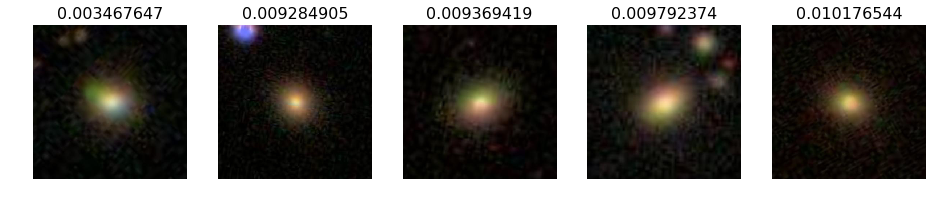

In [166]:
plot_val_with_title(most_by_correct(0, True), "Most correct early-types")

Most correct late-types


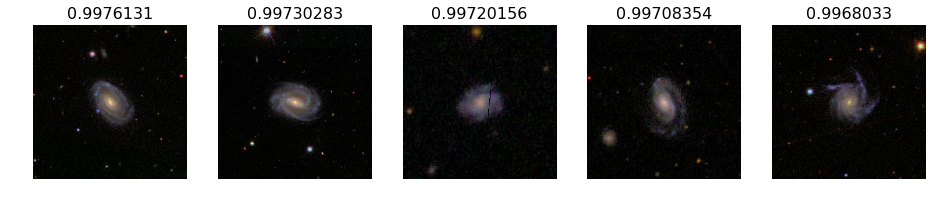

In [167]:
plot_val_with_title(most_by_correct(1, True), "Most correct late-types")

Most correct other


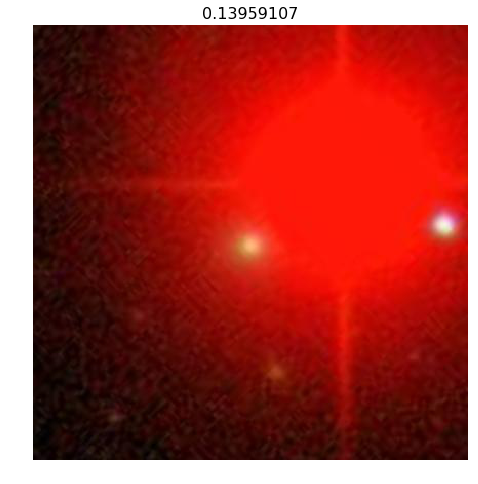

In [168]:
plot_val_with_title(most_by_correct(2, True), "Most correct other")

Most incorrect late-types


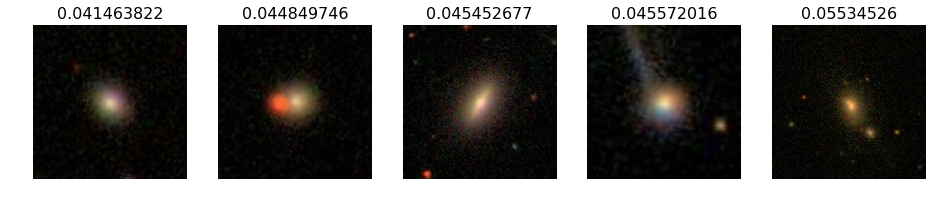

In [171]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect late-types")

Most incorrect early-types


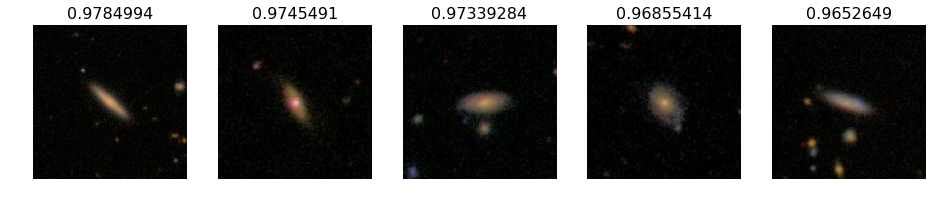

In [170]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect early-types")

#### Some of these have serious artifacts (e.g., different channels are not registered properly). It also seems like some of the "incorrect early-types" have disks (like S0/lenticular galaxies) and thus it is not unexpected to get those wrong. 

#### Interestingly enough, the most-correct early-types seem to have offsets between wavelength channesl. The most-correct late-types are loosely-wound spirals with significant bulge components.

(array([5248.,    0.,    0.,    0.,    0., 7051.,    0.,    0.,    0.,   16.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

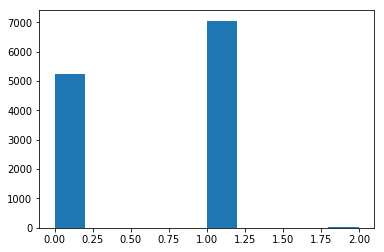

In [175]:
plt.hist(y)

## Larger image sizes now

In [177]:
learn.load(f'{sz}_diff-learn-2')

In [179]:
sz = 64
bs = 16

learn.set_data(get_data(sz, bs))

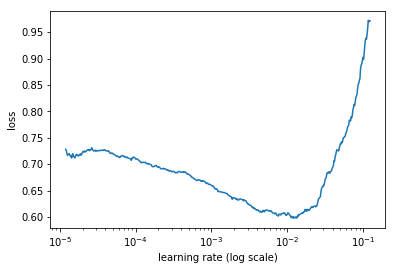

In [184]:
#lrf = learn.lr_find()
learn.sched.plot(n_skip_end=100)

In [185]:
lr = 1e-3 * np.array([1/9, 1/3, 1])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  6%|▌         | 48/770 [00:08<02:13,  5.41it/s, loss=0.718]
epoch      trn_loss   val_loss   accuracy                    
    0      0.59048    0.566548   0.73041   
    1      0.567556   0.549734   0.739342                    
    2      0.575913   0.545788   0.742266                    
    3      0.55832    0.537453   0.744296                    
    4      0.557553   0.535097   0.749492                    
    5      0.556078   0.536002   0.749574                    
    6      0.560586   0.535184   0.749817                    



[array([0.53518]), 0.7498172959272715]

In [186]:
learn.save(f'32-64_diff-learn-1')

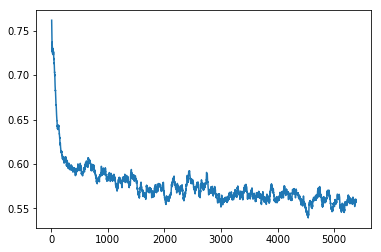

In [187]:
learn.sched.plot_loss()

Still needs work, it seems.

In [188]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=3)
learn.save(f'32-64_diff-learn-2')

HBox(children=(IntProgress(value=0, description='Epoch', max=13), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.555278   0.534701   0.749411  
    1      0.552342   0.53104    0.748762                    
    2      0.550527   0.531422   0.750954                    
    3      0.550857   0.531557   0.75201                     
    4      0.560759   0.529533   0.749168                    
    5      0.559432   0.527229   0.752253                    
    6      0.550992   0.525184   0.752741                    
    7      0.539005   0.524672   0.753634                    
    8      0.552172   0.524025   0.755339                    
    9      0.548195   0.522287   0.755014                    
    10     0.544752   0.524029   0.755014                    
    11     0.550118   0.524106   0.754608                    
    12     0.540359   0.522694   0.754852                    



In [189]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=3)
learn.save(f'32-64_diff-learn-3')

HBox(children=(IntProgress(value=0, description='Epoch', max=13), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.548555   0.522473   0.756313  
    1      0.553264   0.52157    0.753065                    
    2      0.545682   0.523584   0.75607                     
    3      0.548797   0.521902   0.755745                    
    4      0.541167   0.520563   0.755258                    
    5      0.543533   0.522709   0.753715                    
    6      0.533293   0.518589   0.758343                    
    7      0.538612   0.517621   0.756719                    
    8      0.543187   0.519515   0.756882                    
    9      0.541174   0.519059   0.75745                     
    10     0.547303   0.51827    0.758181                    
    11     0.549798   0.516799   0.758019                    
    12     0.544505   0.518042   0.758181                    



### That's clearly worse than before (both the loss and accuracy). Let's scale it up again to 128 by 128 images.

In [190]:
sz = 128
bs = 16

learn.set_data(get_data(sz, bs))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.657576   0.651807   0.628015  
    1      0.654239   0.645078   0.630532                    
    2      0.650382   0.643003   0.634998                    



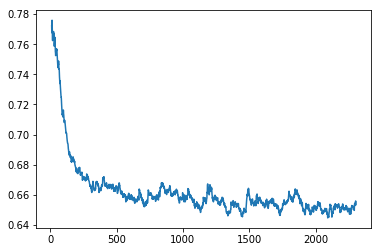

In [192]:
learn.fit(1e-3, 3, cycle_len=1)
learn.sched.plot_loss()

???

## Try directly going from 32x32 -> 128x128

In [195]:
learn.load(f'32_diff-learn-2')

In [198]:
learn.set_data(get_data(128, 16))

In [199]:
lr = 1e-3
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.664899   0.65455    0.626147  
    1      0.657861   0.643217   0.633049                    
    2      0.652898   0.642318   0.636297                    
    3      0.647778   0.638958   0.640763                    
    4      0.647776   0.637387   0.646366                    
    5      0.644953   0.635953   0.640114                    
    6      0.632656   0.635531   0.640032                    



[array([0.63553]), 0.6400324807581358]

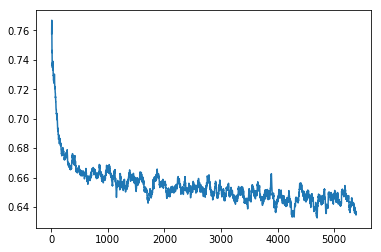

In [200]:
learn.sched.plot_loss()

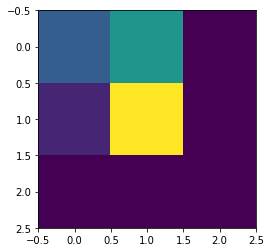

In [203]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds), axis=0)

preds = np.argmax(probs, axis=1)
probs = probs[:,1]

cm = confusion_matrix(y, preds)
plt.imshow(cm)

Most correct late-types
Most incorrect late-types


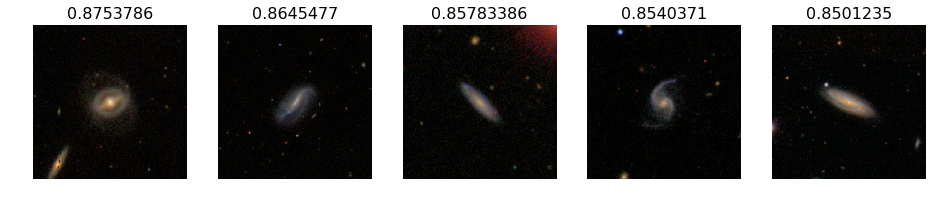

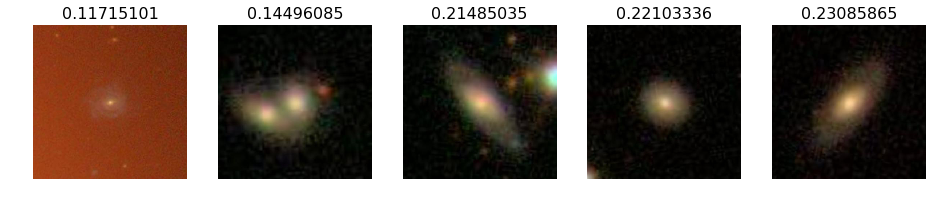

In [204]:
plot_val_with_title(most_by_correct(1, True), "Most correct late-types")
plot_val_with_title(most_by_correct(1, False), "Most incorrect late-types")

Most correct early-types
Most incorrect early-types


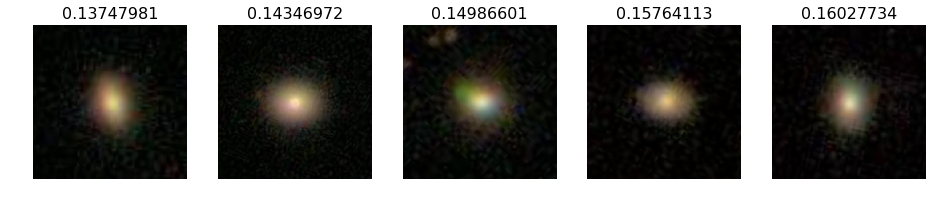

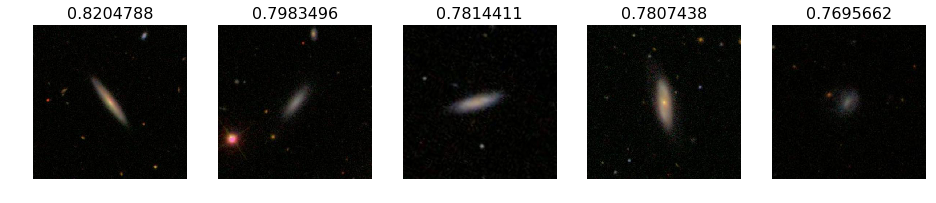

In [206]:
plot_val_with_title(most_by_correct(0, True), "Most correct early-types")
plot_val_with_title(most_by_correct(0, False), "Most incorrect early-types")

# Starting from the beginning again...

In [222]:
# except let's start with 64x64 this time
arch = resnet34
sz = 64
bs = 32

def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    return ImageClassifierData.from_csv(PATH, 'images_training_rev1', f'{PATH}labels.csv', 
                                        test_name='images_test_rev1', val_idxs=val_idxs, 
                                        suffix='.jpg', tfms=tfms, bs=bs)

In [223]:
data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data, precompute=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 77%|███████▋  | 1182/1540 [00:11<00:03, 99.65it/s, loss=2.6]   

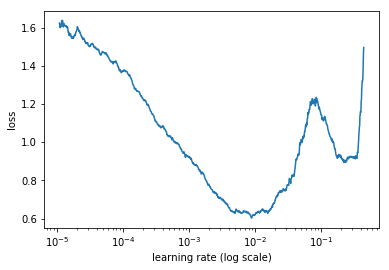

In [224]:
lrf = learn.lr_find()
learn.sched.plot()

In [225]:
learn.fit(1e-3, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  6%|▋         | 98/1540 [00:00<00:14, 98.82it/s, loss=1.43] 
epoch      trn_loss   val_loss   accuracy                       
    0      0.583877   0.514254   0.776695  
    1      0.526569   0.488866   0.782217                       
    2      0.530804   0.477952   0.784409                       



[array([0.47795]), 0.7844092570326942]

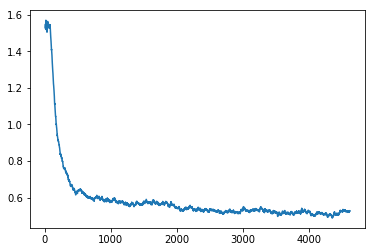

In [226]:
learn.save('64_init')
learn.sched.plot_loss()

In [229]:
learn.precompute = False
lrs = 1e-3 * np.array([1/9, 1/3, 1])

learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.500868   0.471623   0.786033  
    1      0.506352   0.469661   0.788388                      
    2      0.507771   0.469534   0.786927                      
    3      0.501967   0.480031   0.785952                      
    4      0.493974   0.466122   0.786845                      
    5      0.497793   0.471284   0.788713                      
    6      0.49549    0.462533   0.791717                      



[array([0.46253]), 0.7917174178122313]

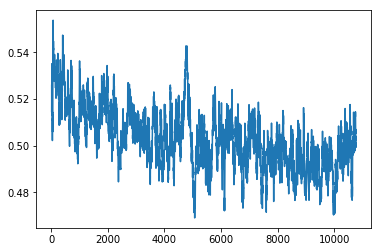

In [230]:
learn.save('64_diff-learn-1')
learn.sched.plot_loss()

In [231]:
learn.fit(lrs, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.485107   0.465491   0.789769  
    1      0.486928   0.465507   0.790824                      
    2      0.49435    0.462814   0.788469                      



[array([0.46281]), 0.7884693463062592]

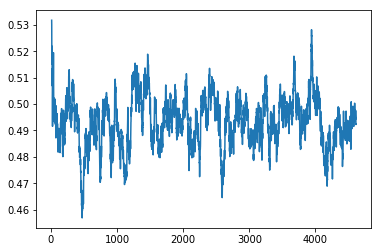

In [232]:
learn.save('64_diff-learn-2')
learn.sched.plot_loss()

### Upsize?

In [235]:
learn.load('64_diff-learn-2')

sz = 128
bs = 16

data = get_data(sz, bs)
learn.set_data(data, precompute=True)

100%|██████████| 4999/4999 [14:09<00:00,  5.89it/s]


In [236]:
# re-fit at higher size
learn.freeze()
learn.fit(1e-3, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.518947   0.483542   0.773934  
    1      0.49779    0.469798   0.782054                       
    2      0.506101   0.46744    0.783922                       



[array([0.46744]), 0.7839220462753382]

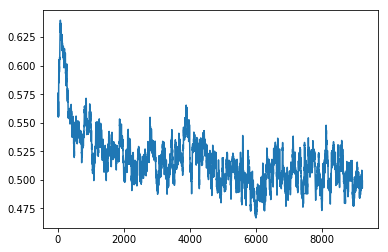

In [237]:
learn.save('64-128_init')
learn.sched.plot_loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.52088    0.480799   0.7797    
    1      0.496462   0.470521   0.784978                      
    2      0.485336   0.463196   0.784896                      
    3      0.494694   0.470405   0.784084                      
    4      0.494846   0.463491   0.785384                      
    5      0.454455   0.467355   0.784247                      
    6      0.477874   0.45954    0.788551                      



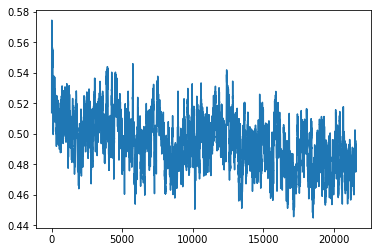

In [238]:
learn.unfreeze()

lrs = 1e-3 * np.array([1/9, 1/3, 1])
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

learn.save('64-128_diff-learn-1')
learn.sched.plot_loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.469107   0.460918   0.791068  
    1      0.492972   0.459361   0.786439                      
    2      0.476699   0.466797   0.785059                      
    3      0.510153   0.458389   0.78985                       
    4      0.471087   0.456319   0.789038                      
    5      0.465739   0.4624     0.788226                      
    6      0.471466   0.470285   0.787657                      



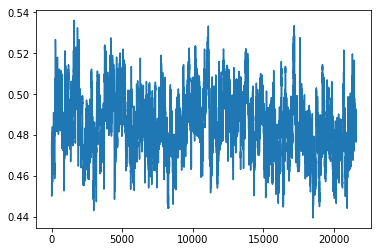

In [239]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

learn.save('64-128_diff-learn-2')
learn.sched.plot_loss()

### Test?

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds), axis=0)

preds = np.argmax(probs, axis=1)
probs = probs[:,1]

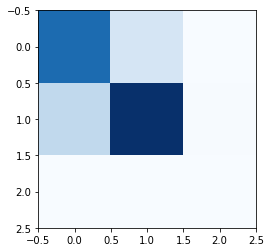

In [269]:
cm = confusion_matrix(y, preds)
plt.imshow(cm, cmap='Blues')

Most incorrect late-types


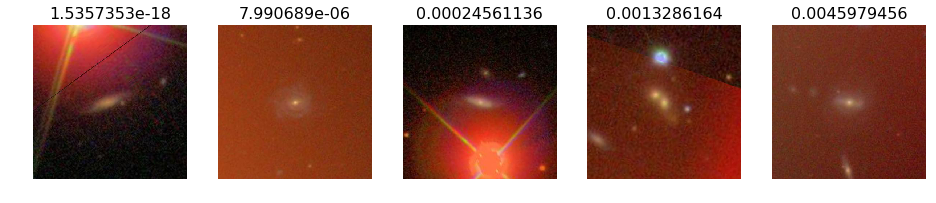

In [263]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect late-types")

Most incorrect early-types


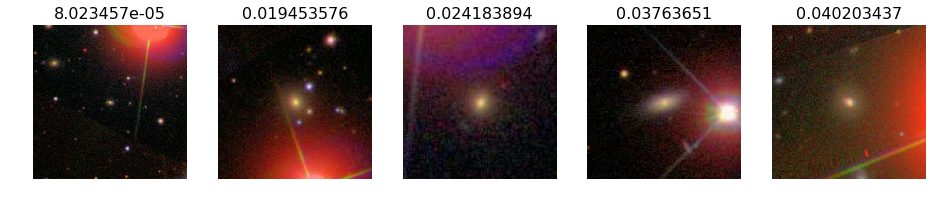

In [267]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect early-types")

Most incorrect "other"


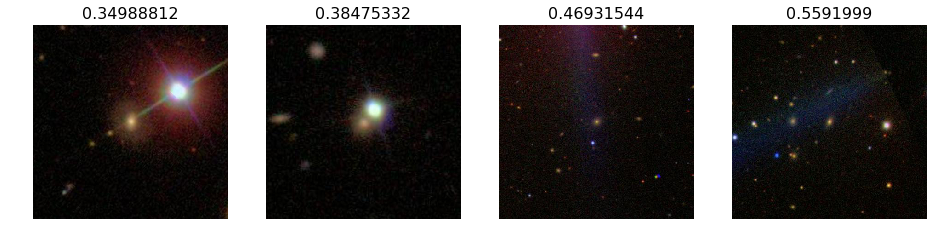

In [268]:
plot_val_with_title(most_by_correct(2, False), 'Most incorrect "other"')

Most uncertain predictions


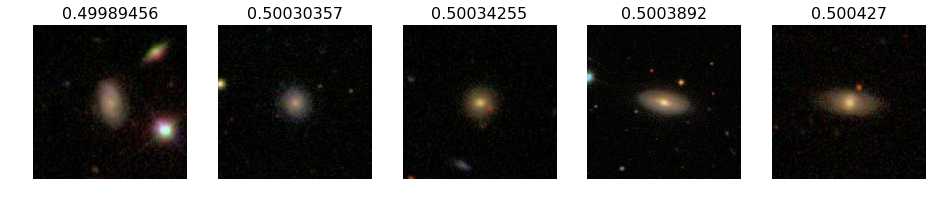

In [262]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:5]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

### Verdict
The convnet still has a ways to go. Then again, there are a ton of artifacts in the data set. I'm curious why the 32x32 images still perform better than 64x64 or 128x128.